In [1]:
from SDP_interaction_inference.constraints import Constraint
from SDP_interaction_inference import optimization
from SDP_interaction_inference.dataset import Dataset
from SDP_interaction_inference.correlation import Correlation
from SDP_interaction_inference import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import scipy
import tqdm
from copy import deepcopy
import matplotlib.patches
import corner
import plotly
import plotly.graph_objects as go

# Correlation Investigation

## Data loading

In [11]:
# read fibroblast transcript counts
data_FIB = pd.read_csv("./Data/GSE151334_FIB_counts_thresh.csv", index_col=0)

# load capture
beta = np.loadtxt("./Capture/beta_FIB.txt")

# load RNA types
biotypes_dict = json.load(open("./Biotypes/biotypes_FIB.json"))

# select indices of protein coding mRNA and non-coding miRNA
pcRNA_indices = [idx for idx, btype in enumerate(biotypes_dict.values()) if btype == "protein_coding"]
miRNA_indices = [idx for idx, btype in enumerate(biotypes_dict.values()) if btype == "miRNA"]

# separate data
data_FIB_pcRNA = data_FIB.iloc[pcRNA_indices]
data_FIB_miRNA = data_FIB.iloc[miRNA_indices]

# amounts: see './Biotypes/updated-biotypes.ipynb' for full pie chart of types
print(f"Total of {data_FIB.shape[0]} genes with mean > 1 present \nSelected {data_FIB_miRNA.shape[0]} non-coding miRNA \nSelected {data_FIB_pcRNA.shape[0]} protein coding (mRNA)")

Total of 11747 genes with mean > 1 present 
Selected 19 non-coding miRNA 
Selected 9296 protein coding (mRNA)


## Setup functions

In [3]:
def construct_dataset(mirna_sample, mrna_dataset, beta, resamples=1000):

    # size
    gene_pairs, cells = mrna_dataset.shape

    # construct paired count dataframe
    counts_df = pd.DataFrame(
        index = [f"Gene-pair-{i}" for i in range(gene_pairs)],
        columns = [f"Cell-{j}" for j in range(cells)]
    )

    # fill with pairs
    for i in range(gene_pairs):
        gene_i = mirna_sample
        gene_j = mrna_dataset.iloc[i]
        gene_pair_ij = list(zip(gene_i, gene_j))
        counts_df.iloc[i] = gene_pair_ij

    # construct dataset object
    data = Dataset()
    data.count_dataset = counts_df
    data.cells = cells
    data.gene_pairs = gene_pairs

    # settings
    data.resamples = resamples

    # set capture
    data.beta = beta

    return data

In [4]:
def direct_correlation_bootstrap_sample(x1_sample, x2_sample, confidence=None, resamples=None):

    # get sample size
    n = len(x1_sample)

    # get bootstrap size: default to sample size
    if resamples is None:
        resamples = n
    # confidence level: default to 95%
    if confidence is None:
        confidence = 0.95

    # initialize random generator
    rng = np.random.default_rng()

    # separate sample pairs
    x1_sample = list(x1_sample)
    x2_sample = list(x2_sample)

    # convert sample to n x 2 array
    sample = np.array([x1_sample, x2_sample]).T

    # bootstrap to N x n x 2 array
    boot = rng.choice(sample, size=(resamples, n))

    # compute correlations
    estimates = np.zeros(resamples)
    for i in range(resamples):

        b1 = boot[i, :, 0]
        b2 = boot[i, :, 1]

        E_xy = np.mean(b1 * b2)
        E_x = np.mean(b1)
        E_y = np.mean(b2)
        E_x2 = np.mean(b1**2)
        E_y2 = np.mean(b2**2)

        sigx = np.sqrt(E_x2 - E_x**2)
        sigy = np.sqrt(E_y2 - E_y**2)

        if sigx == 0.0 or sigy == 0.0:
            corr = np.nan
        else:
            corr = (E_xy - E_x*E_y) / (sigx * sigy)

        # test = scipy.stats.pearsonr(boot[i, :, 0], boot[i, :, 1])
        estimates[i] = corr #test.statistic

    # take quantiles
    alpha = 1 - confidence
    interval = np.quantile(estimates, [(alpha / 2), 1 - (alpha / 2)])

    return interval

In [5]:
def direct_correlation_bootstrap_dataset(mirna_sample, mrna_dataset, confidence=None, resamples=None):

    # size
    gene_pairs, cells = mrna_dataset.shape

    # record bounds
    bounds = np.empty((gene_pairs, 2))
    
    # bootstrap
    for i in tqdm.tqdm(range(gene_pairs)):
        bounds[i, :] = direct_correlation_bootstrap_sample(mirna_sample, mrna_dataset.iloc[i], confidence, resamples)

    return bounds

## Setup results

In [6]:
# select mRNA
mRNA = data_FIB_pcRNA.index

In [7]:
# dataframe to store correlation results
correlation_df = pd.DataFrame(
    index=mRNA
)

## Running

In [8]:
miRNA = "MIR100"

In [12]:
# construct dataset of miRNA paired with all mRNA
dataset = construct_dataset(data_FIB_miRNA.loc[miRNA], data_FIB_pcRNA, beta)

# run correlation test: 1-sided & 2-sided
correlations_1 = Correlation(dataset, printing=False, alternative="less")
correlations_2 = Correlation(dataset, printing=False, alternative="two-sided")

# compute direct bootstrap bounds
correlation_bounds = direct_correlation_bootstrap_dataset(data_FIB_miRNA.loc[miRNA], data_FIB_pcRNA)

# extract results (rho same for 1 or 2 sided test)
rho = [res['statistic'] for res in correlations_1.result_dict.values()]
p1 = [res['pvalue'] for res in correlations_1.result_dict.values()]
p2 = [res['pvalue'] for res in correlations_2.result_dict.values()]
lb = correlation_bounds[:, 0]
ub = correlation_bounds[:, 1]

# store on dataframe
correlation_df['rho'] = rho
correlation_df['p1'] = p1
correlation_df['p2'] = p2
correlation_df['lb'] = lb
correlation_df['ub'] = ub

100%|██████████| 9296/9296 [01:47<00:00, 86.77it/s]


In [26]:
mask = correlation_df['p1'] < 0.05
rho_sig = correlation_df['rho'].loc[mask]
rho_not = correlation_df['rho'].loc[~mask]

In [31]:
rho_sig

CISD1     -0.113163
CNTLN     -0.108510
FBXO5     -0.099272
MAK16     -0.099503
THUMPD1   -0.099567
Name: rho, dtype: float64

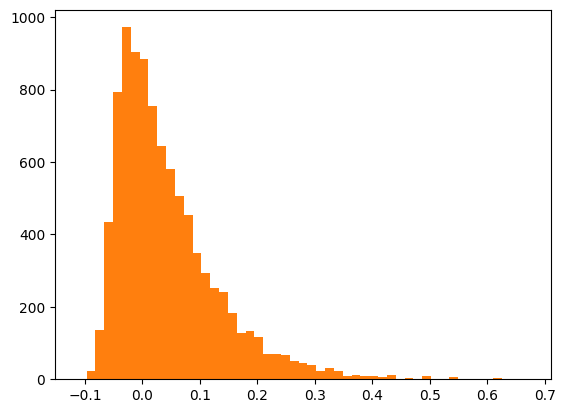

In [27]:
plt.hist(rho_sig, bins=100);
plt.hist(rho_not, bins=50);